# OC_P3 Prédiction consommation de CO2

Bienvenue dans le notebook de prédiction du projet "Anticipez les besoins en consommation de bâtiments".

# Sommaire
- <a href="#C1">I. Feature Engineering</a>
    - 1. Selection des variables pertinentes
    - 2. Encodages des variables catégorielles
    - 3. Division des données en un ensemble de test
    <br></br>
- <a href="#C2">II. Entrainement et test de différens modèles</a>   
    - 1. Linear Regression
    - 2. Decision Tree Regressor
    - 3. Gradient Boosting
    - 4. Random Forest
    - 5. XGBoost
    - 6. GridSearchCV
    <br></br>
- <a href="#C2">III. Feature Importance</a>
    - 1. 
    - 2. 
    - 3. 

In [1]:
import os
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
# récupération du chemin d'accès de la typo et récupération de celle-ci dans la variable prop
fpath = os.path.join(mpl.get_data_path(), r'C:\Users\omira\Downloads\Optima Medium.ttf')
prop = fm.FontProperties(fname=fpath)

text_kwargs = dict(ha='center', va='center', fontsize=14, color='white')

# importation du thème seaborn
sns.set_theme(context='notebook', style='darkgrid', palette='dark', font_scale=1, color_codes=True, rc=None)
sns.set(font=prop.get_name())
# upgrade de la résolution des visualisations
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

# set dark background
plt.style.use("dark_background")

In [4]:
df = pd.read_csv('C:/Users/omira/Desktop/Anticipate-Energy-Needs/buildings_cleaned.csv')

# <a name="C1">I. Feature Engineering</a>

<font size="5">1. Sélection des variables pertinentes</font>

In [9]:
# Cette étape à été effectuée dans le notebook de nettoyage en choisant ces variables :
df[["BuildingType","PrimaryPropertyType","YearBuilt","NumberofBuildings","NumberofFloors","PropertyGFATotal",
                "ENERGYSTARScore","SiteEUI(kBtu/sf)","SiteEnergyUse(kBtu)","Electricity(kWh)",
                "NaturalGas(therms)","TotalGHGEmissions"]]

,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),Electricity(kWh),NaturalGas(therms),TotalGHGEmissions
0,NonResidential,Hotel,1927,1.0,12,88434,60.000,81.699997,7.226362e+06,1.156514e+06,12764.529300,249.98
1,NonResidential,Hotel,1996,1.0,11,103566,61.000,94.800003,8.387933e+06,9.504252e+05,51450.816410,295.86
2,NonResidential,Hotel,1926,1.0,10,61320,56.000,110.800003,6.794584e+06,8.115253e+05,18112.130860,286.43
3,NonResidential,Hotel,1980,1.0,18,175580,75.000,114.800003,1.417261e+07,1.573449e+06,88039.984380,505.01
4,Nonresidential COS,Other,1999,1.0,2,97288,59.625,136.100006,1.208662e+07,2.160444e+06,47151.816410,301.81
...,...,...,...,...,...,...,...,...,...,...,...,...
3336,Nonresidential COS,Office,1990,1.0,1,12294,46.000,69.099998,8.497457e+05,1.536550e+05,3254.750244,20.94
3337,Nonresidential COS,Other,2004,1.0,1,16000,82.250,59.400002,9.502762e+05,1.162210e+05,5537.299805,32.17
3338,Nonresidential COS,Other,1974,1.0,1,13157,78.750,438.200012,5.765898e+06,5.252517e+05,39737.390630,223.54
3339,Nonresidential COS,Mixed Use Property,1989,1.0,1,14101,81.750,51.000000,7.194712e+05,1.022480e+05,3706.010010,22.11


In [5]:
# création du tableau des features
X = df.drop(columns=["TotalGHGEmissions"])
# création de la variable cible, ici la consommation totale d'énergie
y = df["TotalGHGEmissions"]

<font size="5">2. Encodage des variables catégorielles</font>

In [6]:
# dummyfication (encoding des variables categorielles en variables numériques)
X = pd.get_dummies(X)

# transformation log, réduire l'impact des valeurs extrêmes
# ici j'ai choisis les variables les plus asymétrique que j'ai pu trouver dans le notebook de nettoyage
# y = np.log(y)
# X[['SiteEUI(kBtu/sf)','Electricity(kWh)','TotalGHGEmissions','PropertyGFATotal']] = np.log(X[['SiteEUI(kBtu/sf)','Electricity(kWh)','TotalGHGEmissions','PropertyGFATotal']])

In [95]:
# remplacement des valeurs manquantes par la médiane
X['Electricity(kWh)'] = X['Electricity(kWh)'].fillna(X['Electricity(kWh)'].median())
X['TotalGHGEmissions'] = X['TotalGHGEmissions'].fillna(X['TotalGHGEmissions'].median())

# Remplace les valeurs infinies par NaN
X = X.replace([np.inf, -np.inf], np.nan)
# Remplace les NaN par la médiane de chaque colonne
X = X.fillna(X.median())

# Remplace les valeurs infinies par NaN
y = y.replace([np.inf, -np.inf], np.nan)

# Remplace les NaN par la médiane de chaque colonne
y = y.fillna(y.median())

<font size="5">3. Division des données en un ensemble de test</font>

In [7]:
# Division des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# <a name="C2">II. Entrainement et test de différents modèles</a>

<font size="5">1. Linear Regression</font>

In [8]:
# Création de l'objet de régression linéaire
model = LinearRegression()

# Entraînement du modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul de la MSE et R², MAE et RMSE
mse_linear = mean_squared_error(y_test, y_pred)
r2_linear = r2_score(y_test, y_pred)
mae_linear = mean_absolute_error(y_test, y_pred)

# Affichage des résultats
print('MSE:', mse_linear)
print('R²:', r2_linear)
print('MAE:', mae_linear)

MSE: 736.7736795112718
R²: 0.9702737325956518
MAE: 8.479899751478063


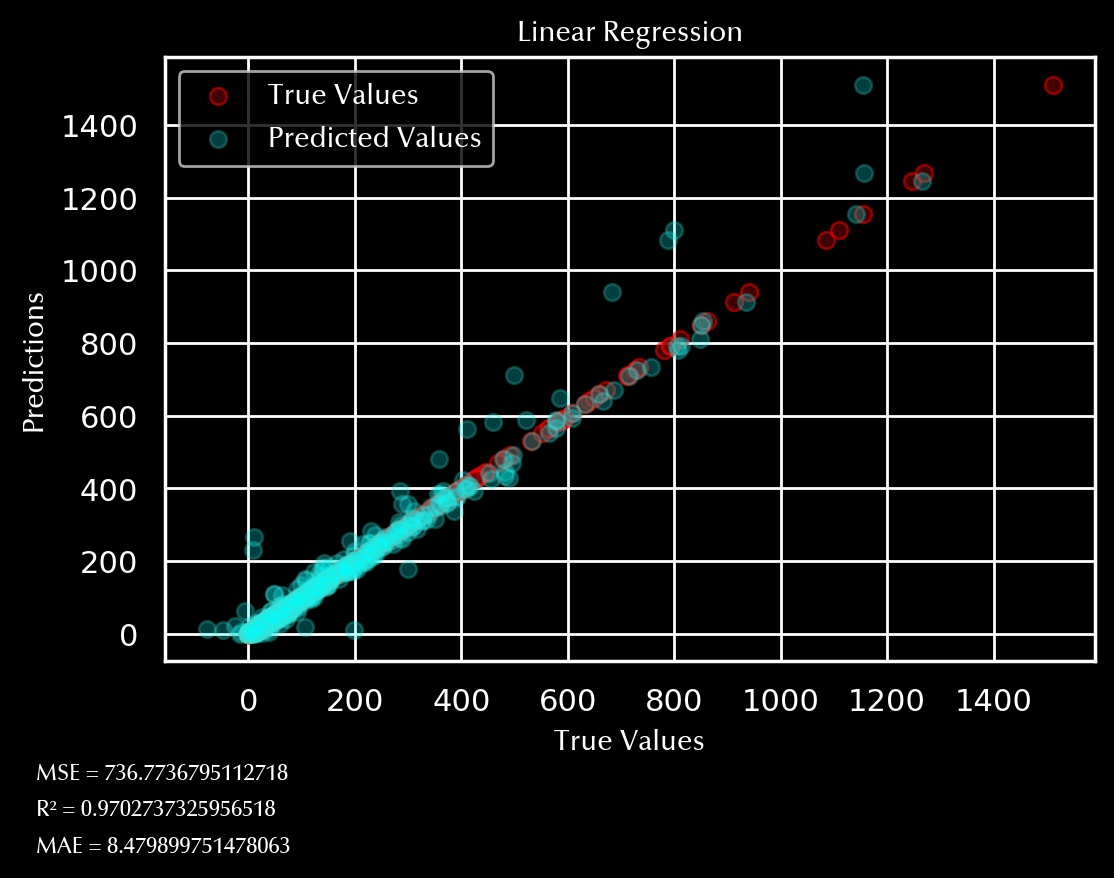

In [20]:
sns.scatterplot(y=y_test, x=y_test, color='maroon', label='True Values', alpha=0.5, edgecolor='red', linewidth=1)
sns.scatterplot(y=y_test, x=y_pred, color='aqua', label='Predicted Values', alpha=0.25, edgecolor='turquoise', linewidth=1)
plt.xlabel('True Values', fontproperties=prop)
plt.ylabel('Predictions', fontproperties=prop)
plt.title('Linear Regression', fontproperties=prop)
plt.legend(loc='best', prop=prop)
plt.text(-400, -400, 'MSE = {}'.format(mse_linear), fontproperties=prop, size=8)
plt.text(-400, -500, 'R² = {}'.format(r2_linear), fontproperties=prop, size=8)
plt.text(-400, -600, 'MAE = {}'.format(mae_linear), fontproperties=prop, size=8)
plt.show()

<font size="5">2. Decision Regression Tree</font>

In [21]:
#Regression Tree

# Initialisation du modèle de régression par arbre de décision
regressor = DecisionTreeRegressor(random_state=42)

# Entraînement du modèle sur le jeu d'entraînement
regressor.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred = regressor.predict(X_test)

# Évaluation du modèle sur le jeu de test
mse_tree = mean_squared_error(y_test, y_pred)
r2_tree = r2_score(y_test, y_pred)
mae_tree = mean_absolute_error(y_test, y_pred)

print("Score R²: ", r2_tree)
print("MSE: ", mse_tree)
print("MAE: ", mae_tree)

Score R²:  0.6304239555687616
MSE:  9160.043486488792
MAE:  18.305620833278358


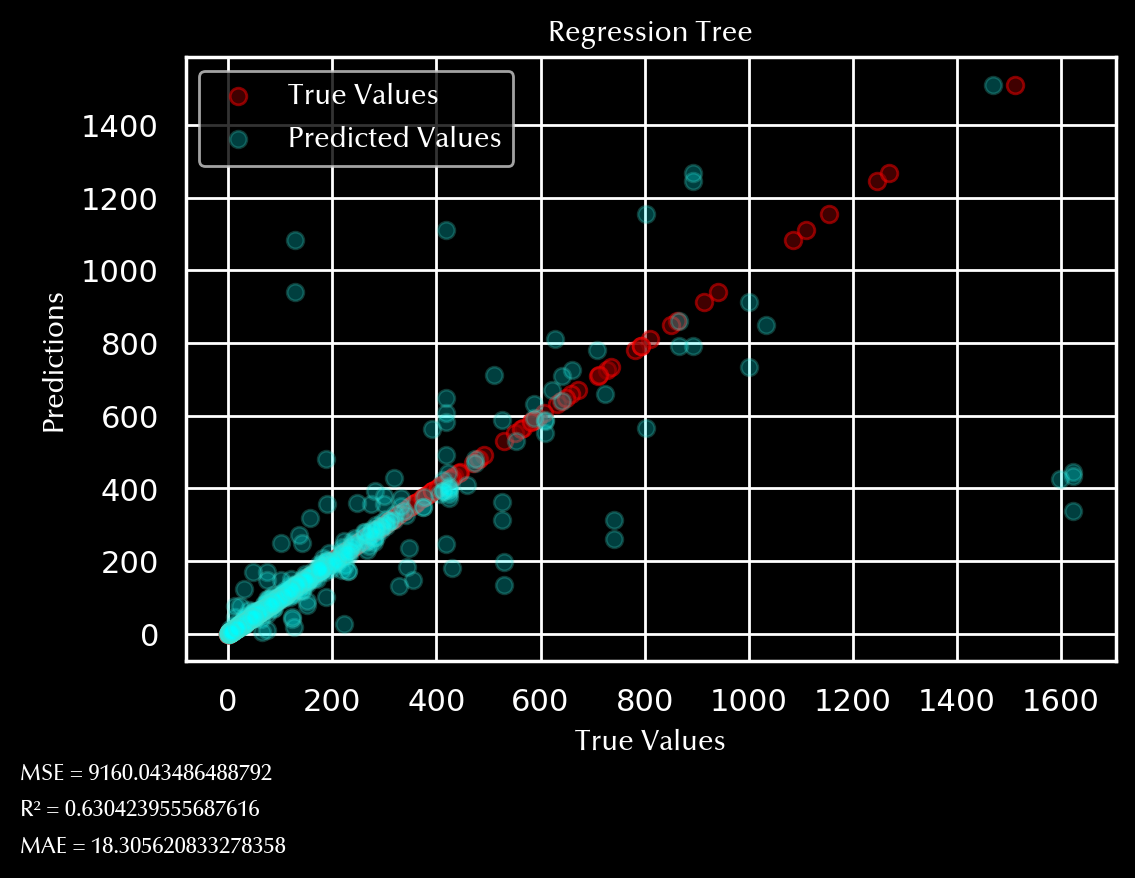

In [22]:
sns.scatterplot(y=y_test, x=y_test, color='maroon', label='True Values', alpha=0.5, edgecolor='red', linewidth=1)
sns.scatterplot(y=y_test, x=y_pred, color='aqua', label='Predicted Values', alpha=0.25, edgecolor='turquoise', linewidth=1)
plt.xlabel('True Values', fontproperties=prop)
plt.ylabel('Predictions', fontproperties=prop)
plt.title('Regression Tree', fontproperties=prop)
plt.legend(loc='best', prop=prop)
plt.text(-400, -400, 'MSE = {}'.format(mse_tree), fontproperties=prop, size=8)
plt.text(-400, -500, 'R² = {}'.format(r2_tree), fontproperties=prop, size=8)
plt.text(-400, -600, 'MAE = {}'.format(mae_tree), fontproperties=prop, size=8)
plt.show()

In [23]:
mse_linear > mse_tree

False

In [24]:
r2_linear > r2_tree

True

<font size="5">3. Gradient Boosting</font>

In [25]:
#Gradient Boosting

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)

# Entraîner le modèle
gbr.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = gbr.predict(X_test)

# Calculer le score MSE et R2
mse_gradient = mean_squared_error(y_test, y_pred)
r2_gradient = r2_score(y_test, y_pred)
mae_gradient = mean_absolute_error(y_test, y_pred)
print("Score MSE: ", mse_gradient)
print("R²: ", r2_gradient)
print("Score MAE: ", mae_gradient)

Score MSE:  4245.730262774251
R²:  0.8286994817707376
Score MAE:  22.548688401532907


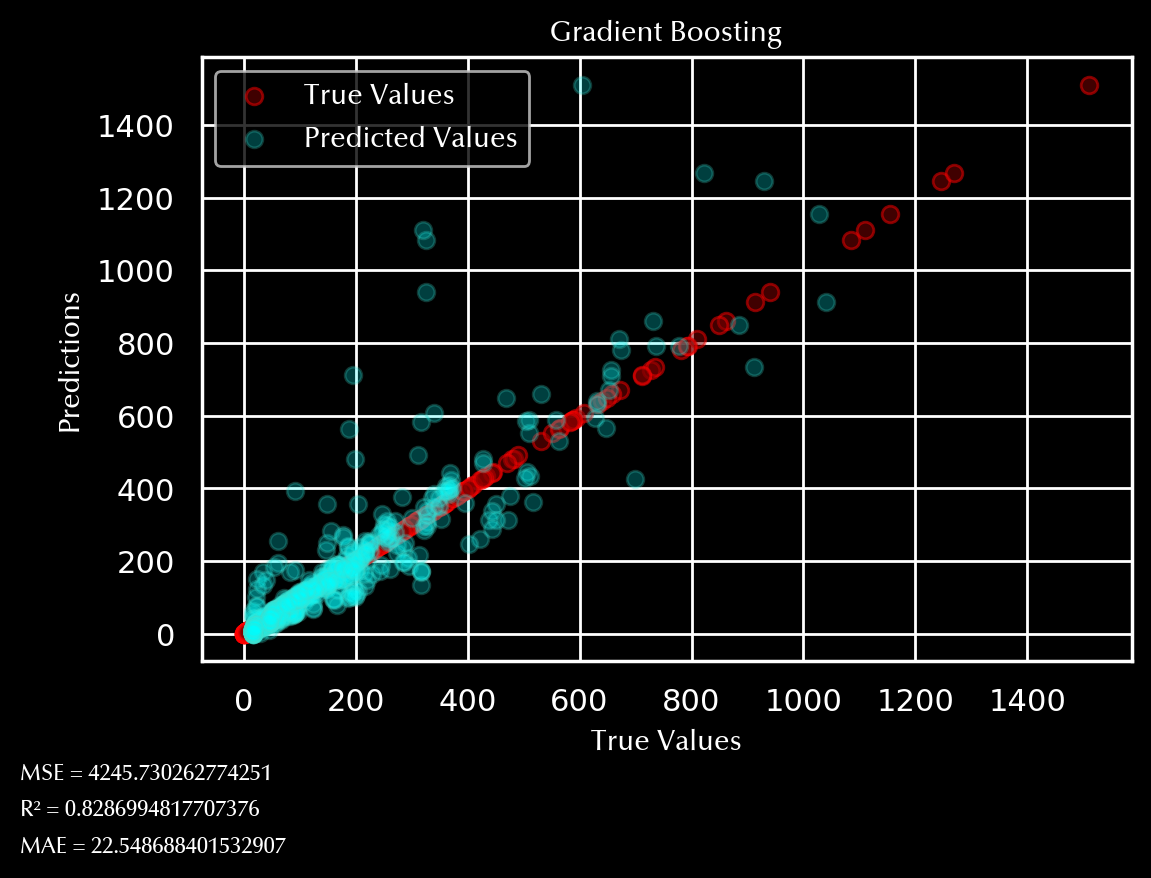

In [26]:
sns.scatterplot(y=y_test, x=y_test, color='maroon', label='True Values', alpha=0.5, edgecolor='red', linewidth=1)
sns.scatterplot(y=y_test, x=y_pred, color='aqua', label='Predicted Values', alpha=0.25, edgecolor='turquoise', linewidth=1)
plt.xlabel('True Values', fontproperties=prop)
plt.ylabel('Predictions', fontproperties=prop)
plt.title('Gradient Boosting', fontproperties=prop)
plt.legend(loc='best', prop=prop)
plt.text(-400, -400, 'MSE = {}'.format(mse_gradient), fontproperties=prop, size=8)
plt.text(-400, -500, 'R² = {}'.format(r2_gradient), fontproperties=prop, size=8)
plt.text(-400, -600, 'MAE = {}'.format(mae_gradient), fontproperties=prop, size=8)
plt.show()

In [157]:
mse_gradient > mse_linear

True

<font size="5">4. Random Forest Regressor</font>

In [27]:
# Random Forest

# Instanciation et entraînement du modèle RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = rf.predict(X_test)

# Calcul de la performance du modèle en utilisant l'erreur quadratique moyenne (MSE)
mse_random_forest = mean_squared_error(y_test, y_pred)
r2_random_forest = r2_score(y_test, y_pred)
mae_random_forest = mean_absolute_error(y_test, y_pred)

print("MSE: %.2f" % mse_random_forest)
print("R²: %.2f" % r2_random_forest)
print("MAE: %.2f" % mae_random_forest)

MSE: 3040.78
R²: 0.88
MAE: 12.56


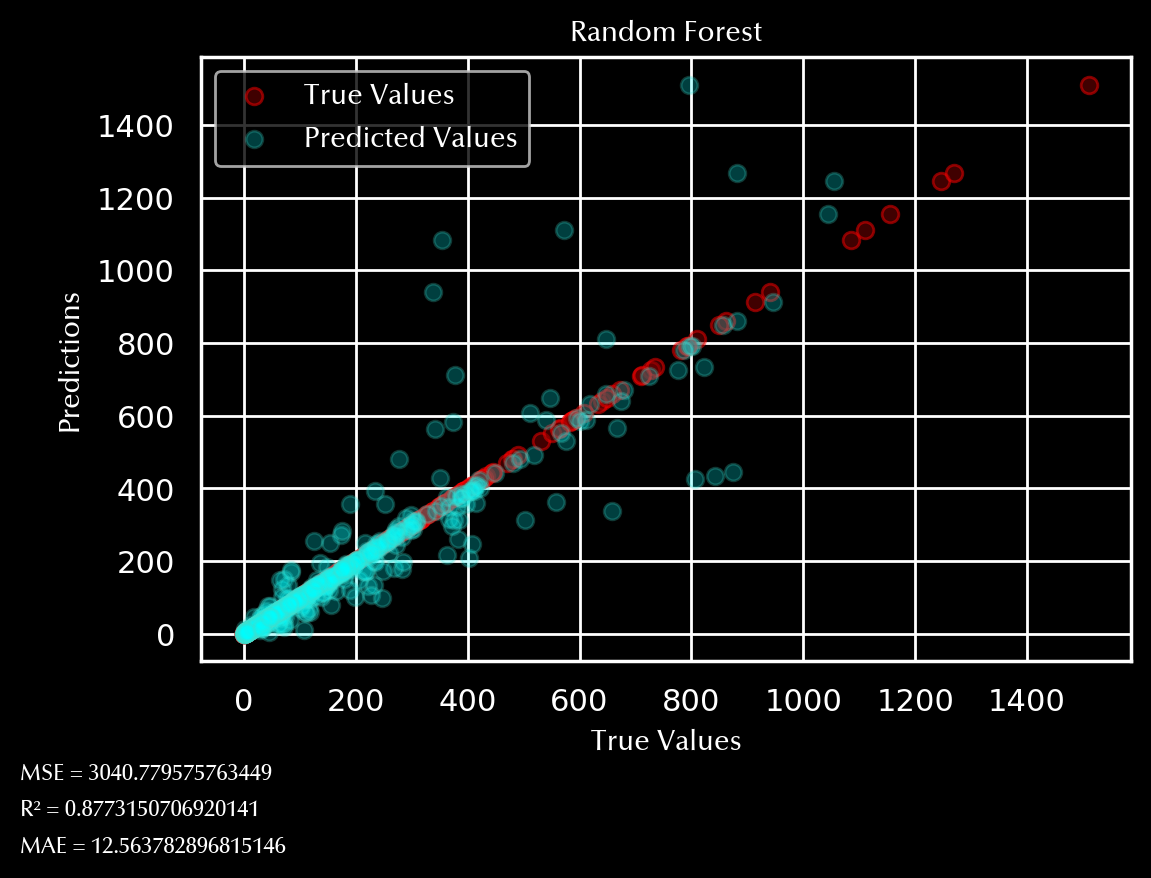

In [28]:
sns.scatterplot(y=y_test, x=y_test, color='maroon', label='True Values', alpha=0.5, edgecolor='red', linewidth=1)
sns.scatterplot(y=y_test, x=y_pred, color='aqua', label='Predicted Values', alpha=0.25, edgecolor='turquoise', linewidth=1)
plt.xlabel('True Values', fontproperties=prop)
plt.ylabel('Predictions', fontproperties=prop)
plt.title('Random Forest', fontproperties=prop)
plt.legend(loc='best', prop=prop)
plt.text(-400, -400, 'MSE = {}'.format(mse_random_forest), fontproperties=prop, size=8)
plt.text(-400, -500, 'R² = {}'.format(r2_random_forest), fontproperties=prop, size=8)
plt.text(-400, -600, 'MAE = {}'.format(mae_random_forest), fontproperties=prop, size=8)
plt.show()

<font size="5">5. XGBoost</font>

In [29]:
# Instanciation et entraînement du modèle XGBRegressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = xgb.predict(X_test)

# Calcul de la performance du modèle en utilisant l'erreur quadratique moyenne (MSE)
mse_xgboost = mean_squared_error(y_test, y_pred)
r2_xgboost = r2_score(y_test, y_pred)
mae_xgboost = mean_absolute_error(y_test, y_pred)

print("MSE: %.2f" % mse_xgboost)
print("R2: %.2f" % r2_xgboost)
print("MSE: %.2f" % mae_xgboost)

MSE: 2940.36
R2: 0.88
MSE: 13.27


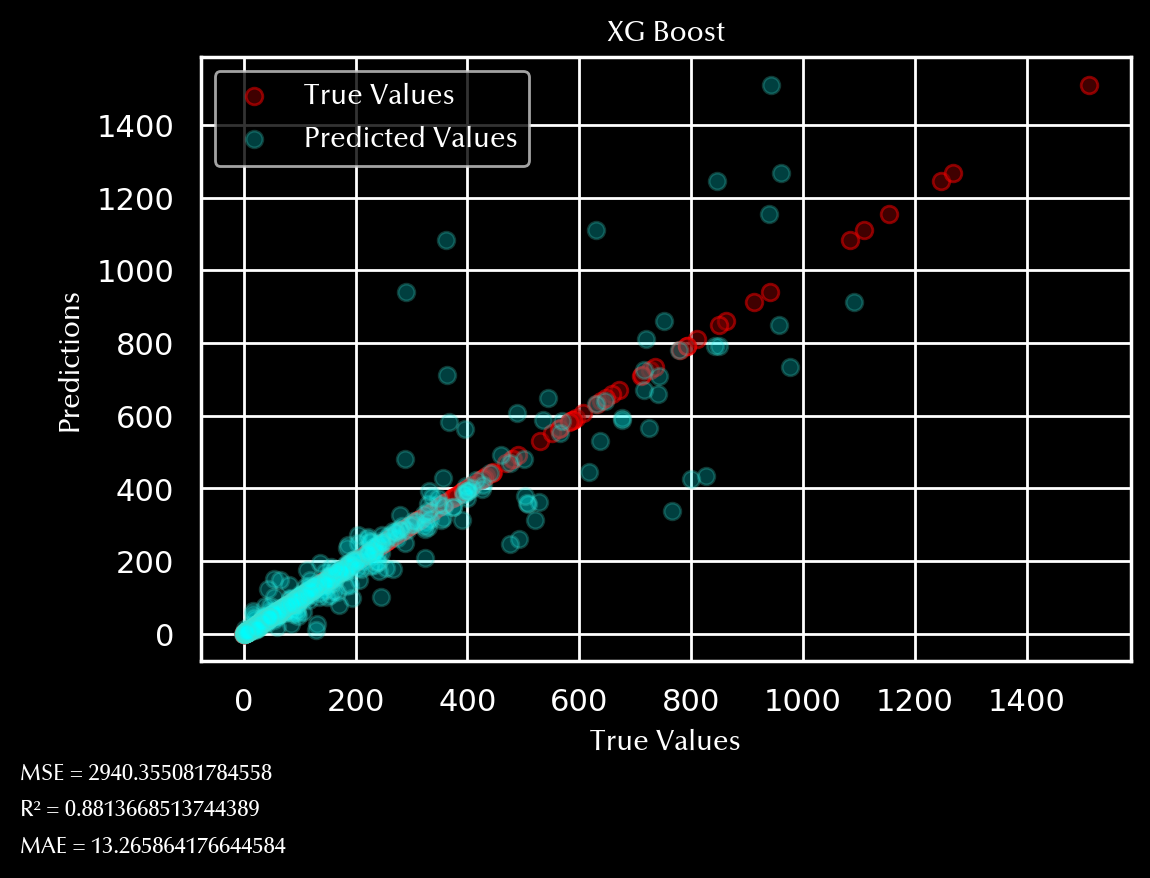

In [30]:
sns.scatterplot(y=y_test, x=y_test, color='maroon', label='True Values', alpha=0.5, edgecolor='red', linewidth=1)
sns.scatterplot(y=y_test, x=y_pred, color='aqua', label='Predicted Values', alpha=0.25, edgecolor='turquoise', linewidth=1)
plt.xlabel('True Values', fontproperties=prop)
plt.ylabel('Predictions', fontproperties=prop)
plt.title('XG Boost', fontproperties=prop)
plt.legend(loc='best', prop=prop)
plt.text(-400, -400, 'MSE = {}'.format(mse_xgboost), fontproperties=prop, size=8)
plt.text(-400, -500, 'R² = {}'.format(r2_xgboost), fontproperties=prop, size=8)
plt.text(-400, -600, 'MAE = {}'.format(mae_xgboost), fontproperties=prop, size=8)
plt.show()

In [162]:
from plotly.offline import iplot, init_notebook_mode; init_notebook_mode(connected=True)

In [52]:
data = [
    {'r': r2_linear, 'theta': 'LinearRegression'},
    {'r': r2_tree, 'theta': 'DecisionTreeRegressor'},
    {'r': r2_random_forest, 'theta': 'RandomForest'},
    {'r': r2_gradient, 'theta': 'GradientBoost'},
    {'r': r2_xgboost, 'theta': 'XGBoost'}
]
fig = px.line_polar(data, r='r', theta='theta',title="Score R2 pour les algorithmes", line_close=True, template='plotly_dark', color_discrete_sequence=['royalblue'])
fig.update_traces(fill='toself')
# change la police
fig.update_layout(
    font=dict(
        family="Optima",
        size=12,
        color="white"
    )
)
# Masquer la ligne représentant les valeurs de 0 à 5 sur l'axe radial
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            showline=False, # masquer la ligne sur l'axe radial
            range=[0,1], # plage maximale de l'axe radial
            showticklabels=False
        )
    )
)

fig.update_layout(
    polar=dict(
        radialaxis=dict(gridcolor='gray', linecolor='gray'),
        angularaxis=dict(gridcolor='gray', linecolor='gray')
    )
)
fig.show()

C:\Users\omira\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [53]:
df = pd.DataFrame(dict(
    r=[mse_linear, mse_tree, mse_random_forest, mse_gradient, mse_xgboost],
    theta=['LinearRegression','DecisionTreeRegressor','RandomForest',
           'GradientBoost', 'XGBoost']))

fig = px.line_polar(df, r='r', theta='theta',title="Score MSE pour les algorithmes", line_close=True, template='plotly_dark', color_discrete_sequence=['royalblue'])
fig.update_traces(fill='toself')
# change la police
fig.update_layout(
    font=dict(
        family="Optima",
        size=12,
        color="white"
    )
)
# Masquer la ligne représentant les valeurs de 0 à 5 sur l'axe radial
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            showline=False, # masquer la ligne sur l'axe radial
            range=[0,10000], # plage maximale de l'axe radial
            showticklabels=False
        )
    )
)

fig.update_layout(
    polar=dict(
        radialaxis=dict(gridcolor='gray', linecolor='gray'),
        angularaxis=dict(gridcolor='gray', linecolor='gray')
    )
)
fig.show()

C:\Users\omira\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [54]:
data = [
    {'r': mae_linear, 'theta': 'LinearRegression'},
    {'r': mae_tree, 'theta': 'DecisionTreeRegressor'},
    {'r': mae_random_forest, 'theta': 'RandomForest'},
    {'r': mae_gradient, 'theta': 'GradientBoost'},
    {'r': mae_xgboost, 'theta': 'XGBoost'}
]
fig = px.line_polar(data, r='r', theta='theta',title="Score MAE pour les algorithmes", line_close=True, template='plotly_dark', color_discrete_sequence=['royalblue'])
fig.update_traces(fill='toself')
# change la police
fig.update_layout(
    font=dict(
        family="Optima",
        size=12,
        color="white"
    )
)
# Masquer la ligne représentant les valeurs de 0 à 5 sur l'axe radial
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            showline=False, # masquer la ligne sur l'axe radial
            range=[0,25], # plage maximale de l'axe radial
            showticklabels=False
        )
    )
)
# changer les couleurs de fond et de la grille
fig.update_layout(
    polar=dict(
        radialaxis=dict(gridcolor='gray', linecolor='gray'),
        angularaxis=dict(gridcolor='gray', linecolor='gray')
    )
)
fig.show()

C:\Users\omira\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<font size="5">6. GridSearchCV</font>

In [42]:
# 3. GridSeachCV -> Utiliser pour trouver les meilleurs hyperpramètres du modèle

model_linear = LinearRegression()
parameters = {'fit_intercept':[True, True], 'normalize':[True, False]}
grid_linear = GridSearchCV(model_linear, parameters, cv=3)

grid_linear.fit(X_train, y_train)

sorted(grid_linear.cv_results_.keys())

best_model = grid_linear.best_estimator_

y_pred_lr_best_model = best_model.predict(X_test)
mse_linear_regression_best_model = mean_squared_error(y_test, y_pred_lr_best_model)

mse_linear_regression_best_model > mse_linear

C:\Users\omira\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



C:\Users\omira\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline

False

In [43]:
#Gradient Boosting grid search
model_gbr = GradientBoostingRegressor(random_state=42)
# gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)

parameters = {'n_estimators':[1,50,100], 'learning_rate':[0.1,0.01], 'max_depth':[1,5]}
grid_gbr = GridSearchCV(model_gbr, parameters, cv=3)

grid_gbr.fit(X_train, y_train)

# sorted(grid_linear.cv_results_.keys())

best_model_gbr = grid_gbr.best_estimator_

y_pred_gbr_best_model = best_model_gbr.predict(X_test)
mse_gbr_best_model = mean_squared_error(y_test, y_pred_gbr_best_model)

mse_gbr_best_model > mse_linear_regression_best_model

True

In [44]:
print(mse_gbr_best_model)
print(mse_linear_regression_best_model)

2825.9022116863416
736.7736795112718


In [45]:
grid_gbr.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [46]:
# Définition du modèle de régression par arbre de décision
model_dtr = DecisionTreeRegressor(random_state=42)

# Paramètres à tester
parameters = {'max_depth': [1, 5, 10], 'min_samples_split': [2, 5, 10]}

# Définition de la grille de recherche
grid_dtr = GridSearchCV(model_dtr, parameters, cv=3)

# Recherche des meilleurs paramètres sur les données d'entraînement
grid_dtr.fit(X_train, y_train)

# Meilleur modèle trouvé
best_model_dtr = grid_dtr.best_estimator_

# Prédictions sur les données de test
y_pred_dtr_best_model = best_model_dtr.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse_dtr_best_model = mean_squared_error(y_test, y_pred_dtr_best_model)

# Comparaison avec le modèle de régression linéaire
mse_dtr_best_model > mse_linear_regression_best_model

True

In [47]:
# Définition du modèle de régression par random forest
model_rfr = RandomForestRegressor(random_state=42)

# Paramètres à tester
parameters = {'n_estimators':[10, 50, 100], 'max_depth':[1, 5, 10], 'min_samples_split':[2, 5, 10]}

# Définition de la grille de recherche
grid_rfr = GridSearchCV(model_rfr, parameters, cv=3)

# Recherche des meilleurs paramètres sur les données d'entraînement
grid_rfr.fit(X_train, y_train)

# Meilleur modèle trouvé
best_model_rfr = grid_rfr.best_estimator_

# Prédictions sur les données de test
y_pred_rfr_best_model = best_model_rfr.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse_rfr_best_model = mean_squared_error(y_test, y_pred_rfr_best_model)

# Comparaison avec le modèle de régression linéaire
mse_rfr_best_model > mse_linear_regression_best_model

True

In [48]:
# Définition du modèle de régression XGBoost
model_xgb = XGBRegressor(random_state=42)

# Paramètres à tester
parameters = {'n_estimators': [10, 50, 100], 'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [1, 5, 10]}

# Définition de la grille de recherche
grid_xgb = GridSearchCV(model_xgb, parameters, cv=3)

# Recherche des meilleurs paramètres sur les données d'entraînement
grid_xgb.fit(X_train, y_train)

# Meilleur modèle trouvé
best_model_xgb = grid_xgb.best_estimator_

# Prédictions sur les données de test
y_pred_xgb_best_model = best_model_xgb.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse_xgb_best_model = mean_squared_error(y_test, y_pred_xgb_best_model)

# Comparaison avec le modèle de régression linéaire
mse_xgb_best_model > mse_linear_regression_best_model

True

In [55]:
data = [
    {'r': mse_linear_regression_best_model, 'theta': 'LinearRegression'},
    {'r': mse_dtr_best_model, 'theta': 'DecisionTreeRegressor'},
    {'r': mse_rfr_best_model, 'theta': 'RandomForest'},
    {'r': mse_gbr_best_model, 'theta': 'GradientBoost'},
    {'r': mse_xgb_best_model, 'theta': 'XGBoost'}
]
fig = px.line_polar(data, r='r', theta='theta',title="Score MSE pour les algorithmes après GridSearchCV", line_close=True, template='plotly_dark', color_discrete_sequence=['royalblue'])
fig.update_traces(fill='toself')
# change la police
fig.update_layout(
    font=dict(
        family="Optima",
        size=12,
        color="white"
    )
)
# Masquer la ligne représentant les valeurs de 0 à 5 sur l'axe radial
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            showline=False, # masquer la ligne sur l'axe radial
            range=[0,10000], # plage maximale de l'axe radial
            showticklabels=False
        )
    )
)
# changer les couleurs de fond et de la grille
fig.update_layout(
    polar=dict(
        radialaxis=dict(gridcolor='gray', linecolor='gray'),
        angularaxis=dict(gridcolor='gray', linecolor='gray')
    )
)
fig.show()

C:\Users\omira\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# <a name="C3">III. Feature Importance</a>

In [51]:
importance = abs(best_model.coef_)
feature_importance = pd.DataFrame(list(zip(X, importance)), columns=["feature", "importance"])
feature_importance = feature_importance.sort_values(by="importance", ascending=False)

print(feature_importance)

                                            feature    importance
18        PrimaryPropertyType_High-Rise Multifamily  5.829620e+01
38                   PrimaryPropertyType_University  5.763379e+01
10                BuildingType_Multifamily HR (10+)  4.685642e+01
20                        PrimaryPropertyType_Hotel  2.293506e+01
11                BuildingType_Multifamily LR (1-4)  2.001091e+01
12                BuildingType_Multifamily MR (5-9)  1.824276e+01
32                   PrimaryPropertyType_Restaurant  1.200366e+01
13                      BuildingType_NonResidential  1.183000e+01
29                        PrimaryPropertyType_Other  1.111149e+01
24         PrimaryPropertyType_Low-Rise Multifamily  1.077532e+01
9                               BuildingType_Campus  1.066444e+01
37  PrimaryPropertyType_Supermarket / Grocery Store  1.050865e+01
27           PrimaryPropertyType_Mixed Use Property  1.010762e+01
35        PrimaryPropertyType_Senior Care Community  9.581668e+00
25        

In [41]:
X

,YearBuilt,NumberofFloors,PropertyGFATotal,NumberofBuildings,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),NaturalGas(therms),TotalGHGEmissions,ENERGYSTARScore,BuildingType_Campus,...,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
0,1927,12,88434,1.0,81.699997,7.226362e+06,12764.529300,249.98,4.094345,0,...,0,0,0,0,0,0,0,0,0,0
1,1996,11,103566,1.0,94.800003,8.387933e+06,51450.816410,295.86,4.110874,0,...,0,0,0,0,0,0,0,0,0,0
2,1926,10,61320,1.0,110.800003,6.794584e+06,18112.130860,286.43,4.025352,0,...,0,0,0,0,0,0,0,0,0,0
3,1980,18,175580,1.0,114.800003,1.417261e+07,88039.984380,505.01,4.317488,0,...,0,0,0,0,0,0,0,0,0,0
4,1999,2,97288,1.0,136.100006,1.208662e+07,47151.816410,301.81,4.088075,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336,1990,1,12294,1.0,69.099998,8.497457e+05,3254.750244,20.94,3.828641,0,...,0,0,0,0,0,0,0,0,0,0
3337,2004,1,16000,1.0,59.400002,9.502762e+05,5537.299805,32.17,4.409763,0,...,0,0,0,0,0,0,0,0,0,0
3338,1974,1,13157,1.0,438.200012,5.765898e+06,39737.390630,223.54,4.366278,0,...,0,0,0,0,0,0,0,0,0,0
3339,1989,1,14101,1.0,51.000000,7.194712e+05,3706.010010,22.11,4.403666,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
list_features = list(X.columns)

In [47]:
list_features

['YearBuilt',
 'NumberofFloors',
 'PropertyGFATotal',
 'NumberofBuildings',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'NaturalGas(therms)',
 'TotalGHGEmissions',
 'ENERGYSTARScore',
 'BuildingType_Campus',
 'BuildingType_Multifamily HR (10+)',
 'BuildingType_Multifamily LR (1-4)',
 'BuildingType_Multifamily MR (5-9)',
 'BuildingType_NonResidential',
 'BuildingType_Nonresidential COS',
 'BuildingType_Nonresidential WA',
 'BuildingType_SPS-District K-12',
 'PrimaryPropertyType_Distribution Center',
 'PrimaryPropertyType_High-Rise Multifamily',
 'PrimaryPropertyType_Hospital',
 'PrimaryPropertyType_Hotel',
 'PrimaryPropertyType_K-12 School',
 'PrimaryPropertyType_Laboratory',
 'PrimaryPropertyType_Large Office',
 'PrimaryPropertyType_Low-Rise Multifamily',
 'PrimaryPropertyType_Medical Office',
 'PrimaryPropertyType_Mid-Rise Multifamily',
 'PrimaryPropertyType_Mixed Use Property',
 'PrimaryPropertyType_Office',
 'PrimaryPropertyType_Other',
 'PrimaryPropertyType_Refrigerated Warehouse

Feature: YearBuilt, Score: 94.75564
Feature: NumberofFloors, Score: 1555.53347
Feature: PropertyGFATotal, Score: 0.51560
Feature: NumberofBuildings, Score: 5702.87566
Feature: SiteEUI(kBtu/sf), Score: -28.86989
Feature: SiteEnergyUse(kBtu), Score: 0.29486
Feature: NaturalGas(therms), Score: -9.62560
Feature: TotalGHGEmissions, Score: -3516.29841
Feature: ENERGYSTARScore, Score: -17435.58101
Feature: BuildingType_Campus, Score: 195301.04248
Feature: BuildingType_Multifamily HR (10+), Score: -112726.91803
Feature: BuildingType_Multifamily LR (1-4), Score: -39215.94512
Feature: BuildingType_Multifamily MR (5-9), Score: -53195.62798
Feature: BuildingType_NonResidential, Score: -13501.03379
Feature: BuildingType_Nonresidential COS, Score: -48813.98194
Feature: BuildingType_Nonresidential WA, Score: -0.00000
Feature: BuildingType_SPS-District K-12, Score: 72152.46650
Feature: PrimaryPropertyType_Distribution Center, Score: -2799.31452
Feature: PrimaryPropertyType_High-Rise Multifamily, Score

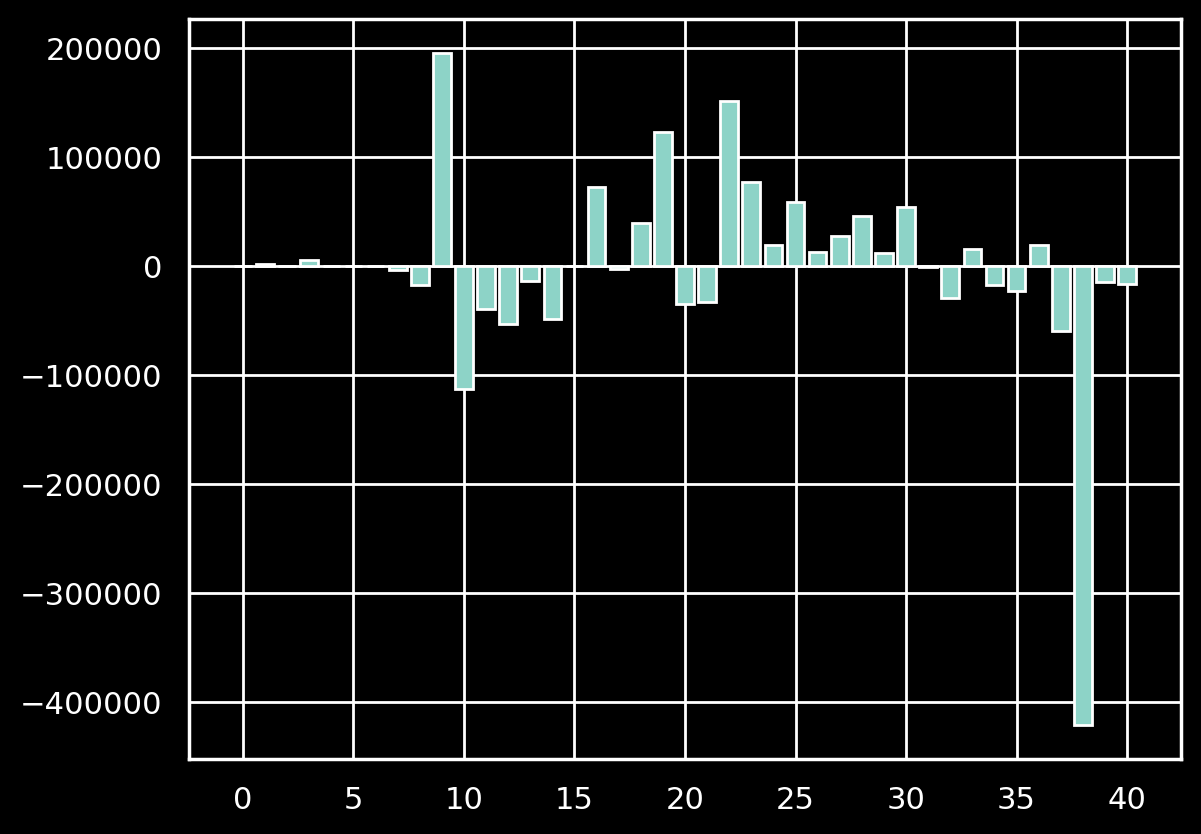

In [49]:
# on affiche les coefficient de la regression linéaire pour voir quels sont les paramètres importants dans la regression de l'electricité
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %s, Score: %.5f' % (list_features[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## GRADIENT BOOSTING FEATURE IMPORTANCE

Feature: YearBuilt, Score: 0.00067
Feature: NumberofFloors, Score: 0.00009
Feature: PropertyGFATotal, Score: 0.00229
Feature: NumberofBuildings, Score: 0.00007
Feature: SiteEUI(kBtu/sf), Score: 0.00033
Feature: SiteEnergyUse(kBtu), Score: 0.92308
Feature: NaturalGas(therms), Score: 0.01099
Feature: TotalGHGEmissions, Score: 0.03767
Feature: ENERGYSTARScore, Score: 0.02334
Feature: BuildingType_Campus, Score: 0.00000
Feature: BuildingType_Multifamily HR (10+), Score: 0.00000
Feature: BuildingType_Multifamily LR (1-4), Score: 0.00000
Feature: BuildingType_Multifamily MR (5-9), Score: 0.00000
Feature: BuildingType_NonResidential, Score: 0.00004
Feature: BuildingType_Nonresidential COS, Score: 0.00006
Feature: BuildingType_Nonresidential WA, Score: 0.00000
Feature: BuildingType_SPS-District K-12, Score: 0.00003
Feature: PrimaryPropertyType_Distribution Center, Score: 0.00000
Feature: PrimaryPropertyType_High-Rise Multifamily, Score: 0.00000
Feature: PrimaryPropertyType_Hospital, Score: 0.0

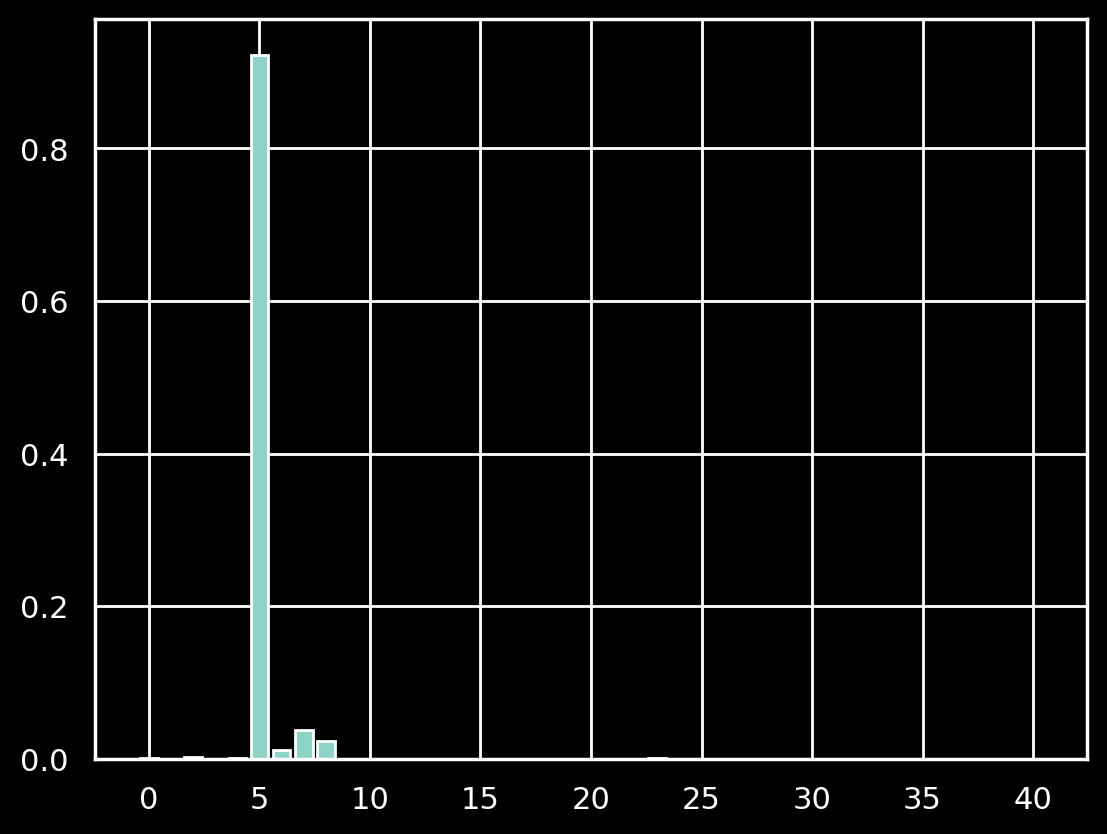

In [53]:
# get importance
importance = best_model_gbr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
print('Feature: %s, Score: %.5f' % (list_features[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
#plt rajouter noms des axes, titres, etc

findfont: Font family ['Optima'] not found. Falling back to DejaVu Sans.


Feature: BuildingType_Nonresidential WA, Score: 0.00000
Feature: PrimaryPropertyType_Hospital, Score: 0.00000
Feature: PrimaryPropertyType_Office, Score: 0.00000
Feature: PrimaryPropertyType_Refrigerated Warehouse, Score: 0.00000
Feature: PrimaryPropertyType_Residence Hall, Score: 0.00000
Feature: PrimaryPropertyType_Self-Storage Facility, Score: 0.00000
Feature: PrimaryPropertyType_Warehouse, Score: 0.00000
Feature: PrimaryPropertyType_Laboratory, Score: 0.00000
Feature: BuildingType_Multifamily LR (1-4), Score: 0.00000
Feature: PrimaryPropertyType_Worship Facility, Score: 0.00000
Feature: PrimaryPropertyType_K-12 School, Score: 0.00000
Feature: PrimaryPropertyType_University, Score: 0.00000
Feature: PrimaryPropertyType_High-Rise Multifamily, Score: 0.00000
Feature: BuildingType_Multifamily HR (10+), Score: 0.00000
Feature: PrimaryPropertyType_Distribution Center, Score: 0.00000
Feature: PrimaryPropertyType_Supermarket / Grocery Store, Score: 0.00000
Feature: PrimaryPropertyType_Resta

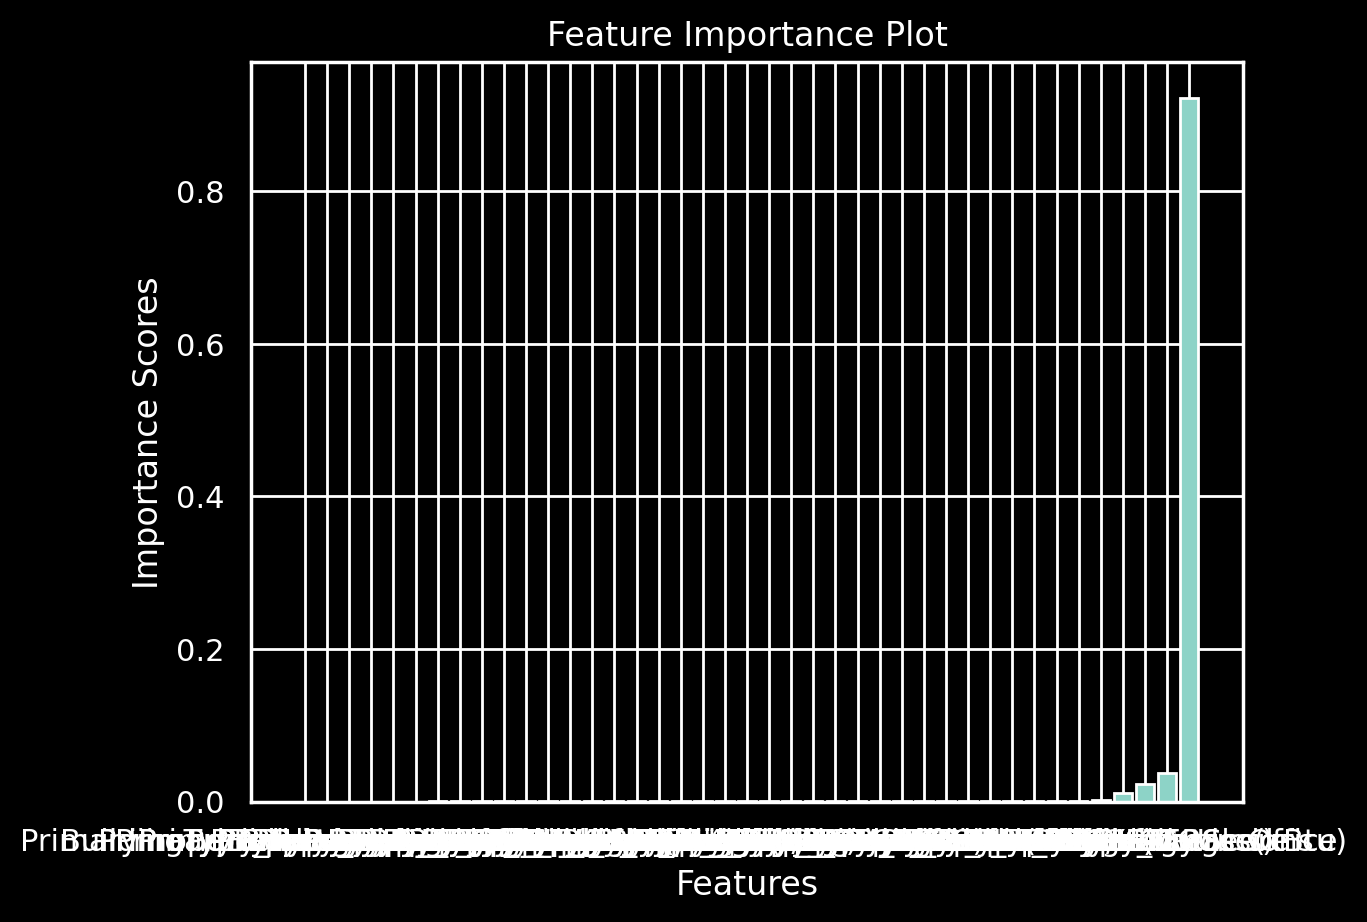

In [54]:
# get importance
importance = best_model_gbr.feature_importances_

# create a list of tuples containing the importance scores and feature names
feature_scores = list(zip(list_features, importance))

# sort the list by the importance score (in ascending order)
sorted_scores = sorted(feature_scores, key=lambda x: x[1])

# print the sorted feature importance scores
for feature, score in sorted_scores:
    print(f"Feature: {feature}, Score: {score:.5f}")

# plot feature importance
plt.bar([x for x in range(len(importance))], [score for feature, score in sorted_scores])
plt.xticks(range(len(importance)), [feature for feature, score in sorted_scores])
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importance Plot')
plt.show()

In [ ]:
# 3eme partie, feature importance

décortiquer les modèles, expliquer quelles variables vont influer

In [ ]:
TO DO semaine prochaine

- Faire la même chose mais avec la variable TotalGHGEmissions plutot que Electricity